**Convolutional Neural Network, in order to recognize individual digits from the SVHN dataset
This version of the code comes from feedback provided during the Udacity ML Nanodegree Capstone
Minor adjustments were performed**

In [17]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from scipy.io import loadmat
from sklearn.utils import shuffle
from datetime import datetime

In [18]:

def y2ind(y):
    N = len(y)
    K = len(set(y))
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind



In [19]:
def error_rate(y_true, y_pred):
    return np.mean(y_true != y_pred)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [20]:
def init_weight(shape, poolsize):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[:-1]) + shape[-1] * np.prod(shape[:-2] / np.prod(poolsize)))
    return w.astype(np.float32)

def conv2d(X, W, b):
    conv_out = tf.nn.conv2d(X, W, strides = [1, 1, 1, 1], padding = 'SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    max_out = tf.nn.max_pool(conv_out, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    return tf.nn.relu(max_out)


def rearrange(X):
    N = X.shape[-1]
    out = np.zeros((N, 32, 32, 3), dtype = np.float32)
    for i in range(N):
        for j in range(3):
            out[i, :, :, j] = X[:, :, j, i]
    return out / 255




In [21]:

# Cropped Digits from http://ufldl.stanford.edu/housenumbers/
train = loadmat('./train_32x32.mat') # N = 73257
test  = loadmat('./test_32x32.mat') # N = 26032
X_train = rearrange(train['X'])
y_train = train['y'].flatten() - 1
print(len(y_train))
del train
X_train, y_train = shuffle(X_train, y_train)
y_train_one_hot = y2ind(y_train)

X_test  = rearrange(test['X'])
y_test  = test['y'].flatten() - 1
del test
y_test_one_hot = y2ind(y_test)

N = X_train.shape[0]
batch_size = 500
num_batches = N // batch_size
M = 500
K = 10

X_train = X_train[:73000,]
y_train = y_train[:73000]
y_train_one_hot = y_train_one_hot[:73000,]
X_test = X_test[:26000,]
y_test = y_test[:26000]
y_test_one_hot = y_test_one_hot[:26000,]

poolsize = (2, 2)
W1_shape = (5, 5, 3, 20)
W1_init = init_weight(W1_shape, poolsize)
b1_bias = np.zeros(W1_shape[-1]).astype(np.float32)
W2_shape = (5, 5, 20, 50)
W2_init = init_weight(W2_shape, poolsize)
b2_bias = np.zeros(W2_shape[-1]).astype(np.float32)
W3_init = np.random.randn(W2_shape[-1] * 8 * 8, M) / np.sqrt(W2_shape[-1] * 8 * 8 + M)
b3_bias = np.zeros(M, dtype = np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_bias = np.zeros(K, dtype = np.float32)

X = tf.placeholder(tf.float32, shape = [batch_size, 32, 32, 3])
y = tf.placeholder(tf.float32, shape = [batch_size, K])


with tf.name_scope("Model"):
    W1 = tf.Variable(W1_init.astype(np.float32), name='Weight1')
    b1 = tf.Variable(b1_bias.astype(np.float32), name='Bias1')
    W2 = tf.Variable(W2_init.astype(np.float32), name='Weight2')
    b2 = tf.Variable(b2_bias.astype(np.float32), name='Bias2')
    W3 = tf.Variable(W3_init.astype(np.float32), name='Weight3')
    b3 = tf.Variable(b3_bias.astype(np.float32), name='Bias3')
    W4 = tf.Variable(W4_init.astype(np.float32), name='Weight4')
    b4 = tf.Variable(b4_bias.astype(np.float32), name='Bias4')


    Z1 = conv2d(X, W1, b1)
    Z2 = conv2d(Z1, W2, b2)
    Z2_shape = Z2.get_shape().as_list()
    Z2rs = tf.reshape(Z2, [Z2_shape[0], np.prod(Z2_shape[1:])])
    Z3 = tf.nn.relu(tf.matmul(Z2rs, W3) + b3)
    pred = tf.matmul(Z3, W4) + b4

with tf.name_scope('Loss'):
        # Minimize error using cross entropy
        cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(pred, y))
        # Loss function with L2 Regularization with beta=0.01
        #regularizers = tf.nn.l2_loss(conv1_w) + tf.nn.l2_loss(conv2_w) + tf.nn.l2_loss(conv3_w) + tf.nn.l2_loss(fc1_w) + tf.nn.l2_loss(fc2_w)
        #cost = tf.reduce_mean(cost + beta * regularizers)
        tf.summary.scalar('Loss', cost)
#cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(pred, y))
#optimizer = tf.train.RMSPropOptimizer(0.0001, decay=0.99, momentum=0.9).minimize(cost)
optimizer = tf.train.AdamOptimizer(0.0001).minimize(cost)
pred_opt = tf.argmax(pred, 1)

LL = []
max_iter = 6
init = tf.global_variables_initializer()

 

73257


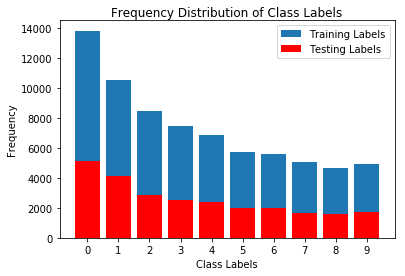

In [22]:
"""
Plotting Class Labels against their respective frequencies in a Bar Graph
"""
from collections import Counter

%matplotlib inline

temp_labels = y_train.reshape(len(y_train)).tolist()
temp_labels = dict(Counter(temp_labels))
plt.bar(range(len(temp_labels)), temp_labels.values(), align='center', label='Training Labels')
plt.xticks(range(len(temp_labels)), temp_labels.keys())
temp_labels = y_test.reshape(len(y_test)).tolist()
temp_labels = dict(Counter(temp_labels))
plt.bar(range(len(temp_labels)), temp_labels.values(), align='center', color='red', label='Testing Labels')
plt.legend()
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Class Labels')
plt.ion()
#============================================================================


In [23]:
   with tf.Session() as sess:
        sess.run(init)
        writer = tf.summary.FileWriter(('./logs1_dir'), graph=tf.get_default_graph())
        for epoch in range(max_iter):
            for i in range(num_batches):
                batch_x = X_train[i * batch_size : (i * batch_size + batch_size), ]
                batch_y = y_train_one_hot[i * batch_size : (i * batch_size + batch_size), ]

                if len(batch_x) == batch_size:
                    sess.run(optimizer, feed_dict = {X: batch_x, y: batch_y})

                    if i % 20 == 0:
                        test_cost = 0
                        predictions = np.zeros(len(X_test))
                        for k in range(len(X_test) // batch_size):
                            batch_x_test = X_test[k * batch_size : (k * batch_size + batch_size), ]
                            batch_y_test = y_test_one_hot[k * batch_size : (k * batch_size + batch_size), ]
                            test_cost += sess.run(cost, feed_dict = {X: batch_x_test, y: batch_y_test})

                            predictions[k * batch_size : (k * batch_size + batch_size)] = sess.run(pred_opt, feed_dict = {X: batch_x_test})
                        error = error_rate(predictions, y_test)
                        acc = accuracy(predictions, y_test)
                        print("Cost / err / accuracy at iteration i=%d, j=%d: %.3f / %.3f / %.3f" % (epoch, i, test_cost, error, acc))
                        LL.append(test_cost)
        writer.flush()


Cost / err / accuracy at iteration i=0, j=0: 58635.899 / 0.804 / 0.196
Cost / err / accuracy at iteration i=0, j=20: 57854.735 / 0.804 / 0.196
Cost / err / accuracy at iteration i=0, j=40: 56993.334 / 0.773 / 0.227
Cost / err / accuracy at iteration i=0, j=60: 55901.754 / 0.697 / 0.303
Cost / err / accuracy at iteration i=0, j=80: 53884.995 / 0.648 / 0.352
Cost / err / accuracy at iteration i=0, j=100: 51084.211 / 0.653 / 0.347
Cost / err / accuracy at iteration i=0, j=120: 47694.212 / 0.611 / 0.389
Cost / err / accuracy at iteration i=0, j=140: 44155.569 / 0.496 / 0.504
Cost / err / accuracy at iteration i=1, j=0: 42992.934 / 0.473 / 0.527
Cost / err / accuracy at iteration i=1, j=20: 39567.314 / 0.444 / 0.556
Cost / err / accuracy at iteration i=1, j=40: 36742.096 / 0.388 / 0.613
Cost / err / accuracy at iteration i=1, j=60: 33642.077 / 0.347 / 0.653
Cost / err / accuracy at iteration i=1, j=80: 31275.790 / 0.322 / 0.678
Cost / err / accuracy at iteration i=1, j=100: 29217.787 / 0.30